In [33]:
import pandas as pd
import json
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
plt.rcParams['figure.figsize'] = 20, 10
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 22})

import datetime

In [34]:
def get_SUB_metering_data(dict_sub_data, date, feeder):
    sub_data=[dict_sub_data[feeder]['P_MW'][date][hour] for hour in [str(x) for x in sorted([int(y) for y in list(dict_sub_data[feeder]['P_MW'][date].keys())])]]        
    return sub_data


def get_weekday(d,m,y):
    #input date, month, year   then return 1 = Monday, 2= Tuesday, ..., 6=Saturday, 7=Sunday 
    date_str='{}/{}/{}'.format(m,d,y)
    date_time_obj=datetime.datetime.strptime(date_str, '%m/%d/%Y')
    return date_time_obj.isoweekday()


def get_half_hour_value(list_quarter_mins):
    sum_kWHr=0
    list_half_hour=[]
    for ind, i in enumerate(list_quarter_mins):
        if ind % 2 ==1:
            sum_kWHr=sum_kWHr+i
            list_half_hour.append(sum_kWHr)
            sum_kWHr=0
        else:
#             sum_kWHr=sum_kWHr+i
            sum_kWHr=0

    return list_half_hour

# plotting propotion graph

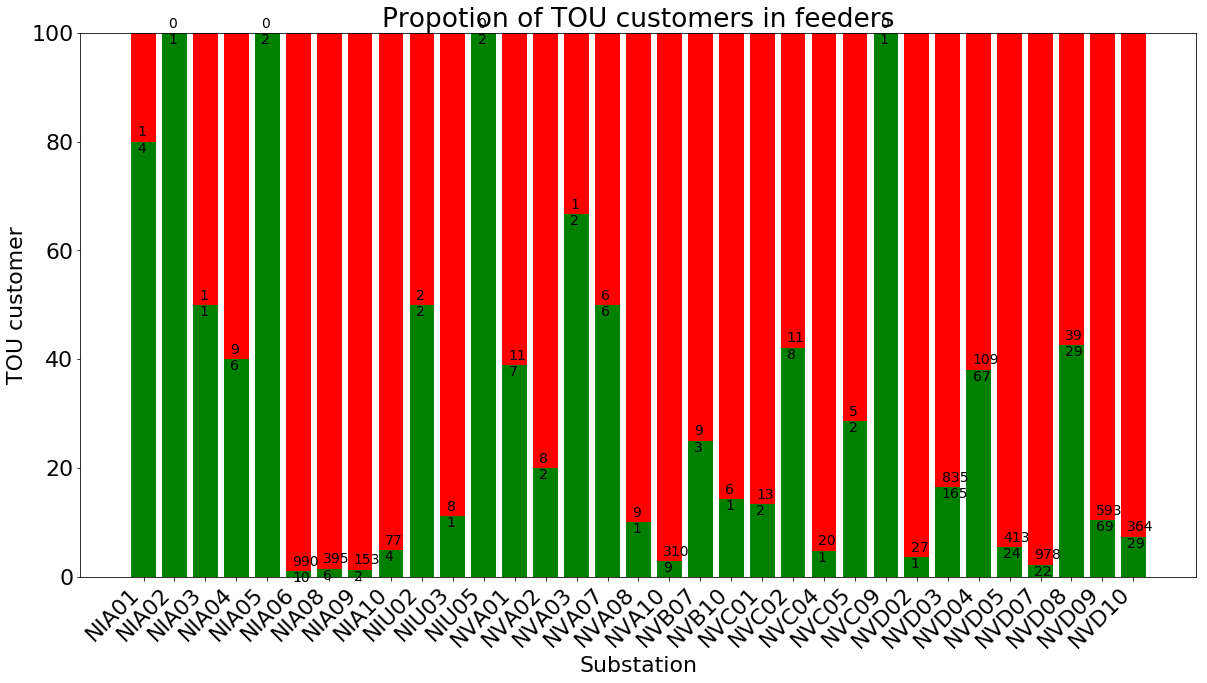

In [5]:
# descript number of AMR customer per feeder
df_1=pd.read_excel('raw_files/meterpoint_with_feeder.xlsx', sheet_name='Sheet1')
df_2=pd.read_csv('raw_files/peano_with_feeder.csv')


dict_meteringpoint={}
for feeder in list(set(df_1['feeder'])):
    df_temp=df_1.drop(list(np.where(df_1['feeder']!=feeder)[0])).copy()
    df_temp=df_temp.reset_index(drop=True)
    df_temp_2=df_2.drop(list(np.where(df_2['feeder']!=feeder)[0])).copy()
    df_temp_2=df_temp_2.reset_index(drop=True)

    number_AMR=len(df_temp['METERPOINTID'])
    number_customer=len(df_temp_2['PEANO'])
    list_meteringpoint_name=[x for x in list(df_temp['METERPOINTID'])]
    list_CTM=[x for x in list(df_temp['CTM'])]
    list_CTD=[x for x in list(df_temp['CTD'])]
    dict_meteringpoint.update({feeder:{'number_customer':number_customer, 'number_AMR':number_AMR, 'AMR_meterinpoint':list_meteringpoint_name, 
                               'CTM':list_CTM, 'CTD':list_CTD}})
    


# plotting code here   
list_feeder_name=sorted(list(dict_meteringpoint.keys()))
number_customer=np.array([dict_meteringpoint[feeder_name]['number_customer'] for feeder_name in list_feeder_name])
number_AMR_customer=np.array([dict_meteringpoint[feeder_name]['number_AMR'] for feeder_name in list_feeder_name])
non_AMR_customer=number_customer-number_AMR_customer

ind = [x for x, _ in enumerate(list_feeder_name)]
propotion_AMR=np.true_divide(number_AMR_customer, number_customer) *100
propotion_non_AMR=np.true_divide(non_AMR_customer, number_customer) *100

plt.bar(ind, propotion_non_AMR, width=0.8, label='TOU', color='r', bottom=propotion_AMR)
plt.bar(ind, propotion_AMR, width=0.8, label='TOU', color='g')


for index,data in enumerate(number_AMR_customer):
    plt.text(x=index-0.2 , y=propotion_AMR[index]-2 , s=f"{data}" , fontdict=dict(fontsize=14))
    
for index,data in enumerate(non_AMR_customer):
    plt.text(x=index-0.2 , y=100-propotion_non_AMR[index]+1 , s=f"{data}" , fontdict=dict(fontsize=14))

plt.xticks(ind, list_feeder_name)
plt.ylabel("TOU customer")
plt.xlabel("Substation")
plt.title("Propotion of TOU customers in feeders")
plt.ylim=1.0

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.savefig('propotion_AMR_meter_in_feeder')
plt.show()
    

# Combine substation data and AMR data

In [6]:
list_sub_name=['NIA', 'NIB', 'NIC']

In [7]:
#read substation file
with open('raw_files/dict_N1_NIA.json') as json_file:  
    sub_data = json.load(json_file)
df_NIA=pd.DataFrame()
list_feeder=['OUT01','OUT02', 'OUT03', 'OUT04','OUT05', 'OUT06', 'OUT07', 'OUT08', 'OUT09','OUT10']

#create date column
df_NIA['Date']=sorted(list(sub_data['OUT01']['P_MW'].keys()))
df_NIA['Month'] = [x.split("/")[0] for x in list(df_NIA['Date'])]
df_NIA['Month'] = [str(x).zfill(2) for x in list(df_NIA['Month'])]

df_NIA['Day'] = [x.split("/")[1] for x in list(df_NIA['Date'])]
df_NIA['Day'] = [str(x).zfill(2) for x in list(df_NIA['Day'])]

df_NIA['Year'] = [x.split("/")[2] for x in list(df_NIA['Date'])]
df_NIA['Year'] = [str(x).zfill(2) for x in list(df_NIA['Year'])]

#create feeders data columns
for feeder in list_feeder:
    df_NIA['SUB_{}'.format(feeder)]=[get_SUB_metering_data(sub_data,date,feeder) for date in list(df_NIA['Date'])]
print('Substation NIA dataframe is created as df_NIA')

Substation NIA dataframe is created as df_NIA


In [8]:
#read kWhr file
with open('raw_files/raw_kwhr_2018_2019_dict.json') as json_file:  
    meter_data = json.load(json_file)
# from dict_meteringpoint

list_of_feeder=['NIA01', 'NIA02', 'NIA03', 'NIA04', 'NIA05', 'NIA06', 'NIA08', 'NIA09', 'NIA10']
# list_of_feeder= ['NIA01']

for feeder in list_of_feeder:
    list_AMR_meteringpoint_in_feeder=[]
    for day, month, year in zip(list(df_NIA['Day']),list(df_NIA['Month']),list(df_NIA['Year'])):
        list_AMR_meteringpoint_in_day=[]
        for AMR_meteringpoint in dict_meteringpoint[feeder]['AMR_meterinpoint']:
            if year in meter_data[str(AMR_meteringpoint)].keys():
                if month in meter_data[str(AMR_meteringpoint)][year].keys():
                    if day in meter_data[str(AMR_meteringpoint)][year][month].keys():
                        list_AMR_meteringpoint_in_day.append({AMR_meteringpoint: [meter_data[str(AMR_meteringpoint)][year][month][day][x] for x in sorted(list(meter_data[str(AMR_meteringpoint)][year][month][day].keys()))]})    
        list_AMR_meteringpoint_in_feeder.append(list_AMR_meteringpoint_in_day)
    df_NIA['AMR_{}'.format(feeder)]=list_AMR_meteringpoint_in_feeder

# print(df_NIA.head())

print('input AMR data in df_NIA')

input AMR data in df_NIA


In [14]:
len(df_NIA['AMR_NIA01'][0][0][21652])

95

#  Create NIA CI

In [15]:
#list_Thai_holiday=['mm/dd', ...]
list_Thai_holiday=['01/01','03/01','04/06','04/12','04/13','04/14','04/15','04/12',
                  '05/01','05/14','04/29','06/27','06/28','06/30','12/08','10/13',
                  '12/05','12/10','12/31']

df_NIA['is_weekend']=[1 if get_weekday(x,y,z) >=6 else 0 for x,y,z in zip(
    list(df_NIA['Day']),list(df_NIA['Month']), list(df_NIA['Year']))]
df_NIA['is_public_holiday']=[1 if '{}/{}'.format(x,y) in list_Thai_holiday else 0 for x,y in zip(list(df_NIA['Month']),list(df_NIA['Day']))]


df_NIA['is_holiday']=[1 if x+y>0 else 0 for x,y in zip(list(df_NIA['is_weekend']), list(df_NIA['is_public_holiday']))]

print('create is_holiday column in df_NIA')

create is_holiday column in df_NIA


In [35]:
NIA_dict={}
for feeder in ['SUB_OUT01', 'SUB_OUT02', 'SUB_OUT03', 'SUB_OUT04', 'SUB_OUT05', 'SUB_OUT06', 'SUB_OUT07', 'SUB_OUT08', 'SUB_OUT09', 'SUB_OUT10']:
# for feeder in ['SUB_OUT01']:
    print(feeder)
    a=np.array([[],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[]])
    temp_df=df_NIA.drop(list(np.where(df_NIA['Year']!='2018')[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
    temp_df=temp_df.drop(list(np.where(temp_df['is_holiday']!=0)[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
    temp_dict={feeder:a}
    
    for day_data in temp_df[feeder]:
#         print(day_data)
        day_data=np.array([[x] for x in day_data])
#         print(day_data)
#         print(len(day_data))
        if len(day_data) == 48:
            temp_dict[feeder]=np.append(temp_dict[feeder], np.array(day_data), axis=1)
#     print(len(temp_dict[feeder][0]))
    new_dict={}
    for key1 in list(temp_dict.keys()):
        new_dict.update({key1:{'working_day':{
            'mean':np.mean(temp_dict[key1], axis=1),
            'Quantile_0.0':np.quantile(temp_dict[key1], 0, axis=1),
            'Quantile_0.05':np.quantile(temp_dict[key1], 0.05, axis=1),
            'Quantile_0.1':np.quantile(temp_dict[key1], 0.1, axis=1),
            'Quantile_0.2':np.quantile(temp_dict[key1], 0.2, axis=1),
            'Quantile_0.3':np.quantile(temp_dict[key1], 0.3, axis=1),
            'Quantile_0.4':np.quantile(temp_dict[key1], 0.4, axis=1),
            'Quantile_0.5':np.quantile(temp_dict[key1], 0.5, axis=1),
            'Quantile_0.6':np.quantile(temp_dict[key1], 0.6, axis=1),
            'Quantile_0.7':np.quantile(temp_dict[key1], 0.7, axis=1),
            'Quantile_0.8':np.quantile(temp_dict[key1], 0.8, axis=1),
            'Quantile_0.9':np.quantile(temp_dict[key1], 0.9, axis=1),
            'Quantile_0.95':np.quantile(temp_dict[key1], 0.95, axis=1),
            'Quantile_1.0':np.quantile(temp_dict[key1], 1.0, axis=1),
            'other_stat_values':'xx'}}}) 
        
    temp_df=df_NIA.drop(list(np.where(df_NIA['Year']!='2018')[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
    temp_df=temp_df.drop(list(np.where(temp_df['is_holiday']!=1)[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
    temp_dict={feeder:a}
    
    for day_data in temp_df[feeder]:
        day_data=np.array([[x] for x in day_data])
#         print(len(day_data))
        if len(day_data) == 48:
            temp_dict[feeder]=np.append(temp_dict[feeder], np.array(day_data), axis=1)
#     print(len(temp_dict[feeder][0]))


    for key1 in list(temp_dict.keys()):
        new_dict[key1].update({'non_working_day':{
            'mean':np.mean(temp_dict[key1], axis=1),
            'Quantile_0.0':np.quantile(temp_dict[key1], 0, axis=1),
            'Quantile_0.05':np.quantile(temp_dict[key1], 0.05, axis=1),
            'Quantile_0.1':np.quantile(temp_dict[key1], 0.1, axis=1),
            'Quantile_0.2':np.quantile(temp_dict[key1], 0.2, axis=1),
            'Quantile_0.3':np.quantile(temp_dict[key1], 0.3, axis=1),
            'Quantile_0.4':np.quantile(temp_dict[key1], 0.4, axis=1),
            'Quantile_0.5':np.quantile(temp_dict[key1], 0.5, axis=1),
            'Quantile_0.6':np.quantile(temp_dict[key1], 0.6, axis=1),
            'Quantile_0.7':np.quantile(temp_dict[key1], 0.7, axis=1),
            'Quantile_0.8':np.quantile(temp_dict[key1], 0.8, axis=1),
            'Quantile_0.9':np.quantile(temp_dict[key1], 0.9, axis=1),
            'Quantile_0.95':np.quantile(temp_dict[key1], 0.95, axis=1),
            'Quantile_1.0':np.quantile(temp_dict[key1], 1.0, axis=1),
            'other_stat_values':'xx'}}) 

    NIA_dict.update(new_dict)

np.save('NIA_CI_dict.npy',NIA_dict)
print('File export to NIA_CI_dict.npy')

SUB_OUT01


AttributeError: module 'numpy' has no attribute 'quantile'

# convert to primary kWhr

In [16]:
# get current ratios
metering_df=pd.read_excel('raw_files/meterpoint_with_feeder.xlsx')
dict_meteringpoint_temp={x:{'CTM':y, 'CTD':z}for x,y,z in zip(list(metering_df['METERPOINTID']), list(metering_df['CTM']), list(metering_df['CTD']))}
print('create dict_meteringpoint_temp containing meteringpoint and CTM, CTD values')

create dict_meteringpoint_temp containing meteringpoint and CTM, CTD values


In [17]:
df_AMR_data=pd.DataFrame()
df_AMR_data['Month']=df_NIA['Month']
df_AMR_data['Day']=df_NIA['Day']
df_AMR_data['Year']=df_NIA['Year']

for out_num in ['01','02','03','04','05','06','08','09','10']:

    df_AMR_data['AMR_OUT{}'.format(out_num)]=[[{list(AMR_data.keys())[0]:np.array([AMR_data[list(AMR_data.keys())[0]]])/dict_meteringpoint_temp[list(AMR_data.keys())[0]]['CTM']*dict_meteringpoint_temp[list(AMR_data.keys())[0]]['CTD']/4} for AMR_data in date_data] for date_data in df_NIA['AMR_NIA{}'.format(out_num)]]
#     df_AMR_data['AMR_OUT{}'.format(out_num)]=[[{list(AMR_data.keys())[0]:np.array([AMR_data[list(AMR_data.keys())[0]]])*dict_meteringpoint_temp[list(AMR_data.keys())[0]]['CTM']/dict_meteringpoint_temp[list(AMR_data.keys())[0]]['CTD']/4000} for AMR_data in date_data] for date_data in df_NIA['AMR_NIA{}'.format(out_num)]]

    
# df_AMR_data['SUM_AMR_OUT01']

for feeder in ['01','02','03','04','05','06','08','09','10']:
#     print(feeder)
    list_sum_AMR_feeder=[]
    for x in df_AMR_data['AMR_OUT{}'.format(feeder)]:
#         print('new date')
        list_sum_AMR_date=[]
        bad_date=0
        sum_AMR_data=np.zeros(shape=(1,96))
        for y in x:
            if len(y[list(y.keys())[0]][0]) == 96:
                sum_AMR_data = sum_AMR_data+y[list(y.keys())[0]]
            else: 
                bad_data=1
        if bad_date==0:
            list_sum_AMR_date.append(sum_AMR_data)
        else:
            list_sum_AMR_date.append('None')
        list_sum_AMR_feeder.append(list_sum_AMR_date)
    df_AMR_data['SUM_AMR_OUT{}'.format(feeder)]=list_sum_AMR_feeder

    
    
sum_AMR_load=[]
for a,b,c, d,e,f, g,h,i in zip(df_AMR_data['SUM_AMR_OUT01'], df_AMR_data['SUM_AMR_OUT02'], df_AMR_data['SUM_AMR_OUT03'],
                              df_AMR_data['SUM_AMR_OUT04'], df_AMR_data['SUM_AMR_OUT05'], df_AMR_data['SUM_AMR_OUT06'],
                              df_AMR_data['SUM_AMR_OUT08'], df_AMR_data['SUM_AMR_OUT09'], df_AMR_data['SUM_AMR_OUT10']):
    sum_AMR_load.append([a[0]+b[0]+c[0]+d[0]+e[0]+f[0]+g[0]+h[0]+i[0]])
df_AMR_data['SUM_AMR_LOAD']=sum_AMR_load
# print(df_AMR_data.head())

print('create AMR data dataframe as df_AMR_data')
print('which content convert kWhr data and sum or AMR consumption in each feeder')

create AMR data dataframe as df_AMR_data
which content convert kWhr data and sum or AMR consumption in each feeder


In [19]:
list(df_AMR_data)

['Month',
 'Day',
 'Year',
 'AMR_OUT01',
 'AMR_OUT02',
 'AMR_OUT03',
 'AMR_OUT04',
 'AMR_OUT05',
 'AMR_OUT06',
 'AMR_OUT08',
 'AMR_OUT09',
 'AMR_OUT10',
 'SUM_AMR_OUT01',
 'SUM_AMR_OUT02',
 'SUM_AMR_OUT03',
 'SUM_AMR_OUT04',
 'SUM_AMR_OUT05',
 'SUM_AMR_OUT06',
 'SUM_AMR_OUT08',
 'SUM_AMR_OUT09',
 'SUM_AMR_OUT10',
 'SUM_AMR_LOAD']

In [26]:
len(df_AMR_data['AMR_OUT01'][0][0][21652][0])

95

In [32]:
df_AMR_data

,Month,Day,Year,AMR_OUT01,AMR_OUT02,AMR_OUT03,AMR_OUT04,AMR_OUT05,AMR_OUT06,AMR_OUT08,...,SUM_AMR_OUT04,SUM_AMR_OUT05,SUM_AMR_OUT06,SUM_AMR_OUT08,SUM_AMR_OUT09,SUM_AMR_OUT10,SUM_AMR_LOAD,is_weekend,is_public_holiday,is_holiday
0,01,01,2018,[{21652: [[3.79008030e-03 3.69600029e-03 3.675...,[{42432: [[0.52156164 0.51392324 0.50938724 0....,[{66543: [[0.0564186 0.0542346 0.0545706 0.055...,[{21654: [[1.14240009e-03 1.12980009e-03 1.121...,[{21655: [[0.0168336 0.0164934 0.01659 0.016...,[{44834: [[0.14444641 0.12929281 0.14117601 0....,[{56448: [[0.18203809 0.15216769 0.17105089 0....,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,1,1
1,01,01,2019,[{21652: [[0.00692832 0.00690816 0.006888 0....,[{42432: [[0.47295364 0.47826244 0.45575044 0....,[{66543: [[0.0419748 0.0426594 0.0416094 0.041...,[{21654: [[1.51620012e-03 2.51160020e-03 1.323...,[{21655: [[0.0234108 0.0232638 0.0221886 0.022...,[{44834: [[0.15892801 0.15217441 0.14855681 0....,[{56448: [[0.15105889 0.15644161 0.13716865 0....,...,"[[[0.1120467081549576, 0.10900810781604368, 0....","[[[0.0668304052582244, 0.06590220518519341, 0....","[[[2.0188217076474873, 1.982685555360513, 2.14...","[[[2.2496862032365357, 2.079330242510575, 1.99...","[[[0.04995326372096315, 0.05541662415082111, 0...","[[[1.3801123257598398, 1.4793062929192107, 1.3...","[[[7.261807350995903, 7.091979040598285, 6.468...",0,1,1
2,01,10,2018,[{21652: [[0.81467238 0.00581952 0.96504584 0....,[{42432: [[0.62867845 0.63534245 0.59472005 0....,[{66543: [[0.0474096 0.0478044 0.0438648 0....,[{21654: [[0.00168 0.0016842 0.0016044 0....,[{21655: [[0.0184884 0.0185346 0.0176946 0....,[{44834: [[0.32092483 0.32085763 0.25598722 0....,[{56448: [[0.34370787 0.34921827 0.28091618 0....,...,"[[[0.23192751557398883, 0.7934344592311394, 0....","[[[0.1037316081616156, 0.10442880821647124, 0....","[[[4.648563192873795, 4.459866375420948, 3.639...","[[[2.3855660889022228, 2.138320209994563, 1.94...","[[[0.25929483993269986, 0.27689448159013436, 0...","[[[2.4660337998479362, 2.4310314822249333, 1.2...","[[[11.998377482585468, 11.555442206780716, 11....",0,0,0
3,01,10,2019,[{21652: [[6.64325812e-01 7.33824058e-03 7.284...,[{42432: [[0.52056484 0.53145124 0.43686723 0....,[{66543: [[0.0420336 0.0430164 0.041328 0....,[{21654: [[1.99920016e-03 1.46160011e-03 1.457...,[{21655: [[0.0225246 0.0228354 0.022197 0....,[{44834: [[0.32874243 0.31531362 0.40428643 0....,[{56448: [[0.27961922 0.26915618 0.2221229 0....,...,"[[[0.6973758506286702, 0.6999372514754225, 0.6...","[[[0.09745680766791338, 0.09763740768212309, 0...","[[[4.172589195913196, 4.236209714684931, 3.373...","[[[2.3353320968725404, 2.130167224537, 2.17199...","[[[0.12499884976190528, 0.12141374934348263, 0...","[[[1.5374488326068954, 1.4940513690083737, 0.5...","[[[11.22962588203838, 10.401222592176415, 8.43...",0,0,0
4,01,11,2018,[{21652: [[7.26035577e-01 5.32896042e-03 9.645...,[{42432: [[0.61625765 0.59235685 0.57214085 0....,[{66543: [[0.0450618 0.043974 0.043911 0....,[{21654: [[1.43640011e-03 1.44060011e-03 1.436...,[{21655: [[0.0189084 0.0194502 0.0187362 0....,[{44834: [[0.35598083 0.37022723 0.28788482 0....,[{56448: [[0.36634083 0.33665859 0.29656034 0....,...,"[[[0.13100780686545482, 0.20197911128198054, 0...","[[[0.10852380853866626, 0.10889340856774636, 0...","[[[4.597293980873053, 4.46650875747133, 3.8427...","[[[2.33361236077908, 2.0520631915136858, 2.335...","[[[0.2684676009271063, 0.23906087861338182, 0....","[[[2.303962794223333, 2.263865908121227, 1.073...","[[[12.129390068693562, 10.758197720006232, 10....",0,0,0
5,01,11,2019,[{21652: [[9.66638476e-01 3.04073304e-01 9.674...,[{42432: [[0.47424164 0.46599844 0.46780164 0....,[{66543

In [17]:
#calculate load factor
df_AMR_data['LF_SUB']=[x[0].mean()/x[0].max() if x[0].max()!=0 else 'None' for x in df_AMR_data['SUM_AMR_LOAD']]

for feeder in ['01','02','03','04','05','06','08','09','10']:
    df_AMR_data['LF_OUT{}'.format(feeder)]=[x[0].mean()/x[0].max() if x[0].max()!=0 else 'None' for x in df_AMR_data['SUM_AMR_OUT{}'.format(feeder)]]
    
print('create load factor column of AMR value')

create load factor column of AMR value


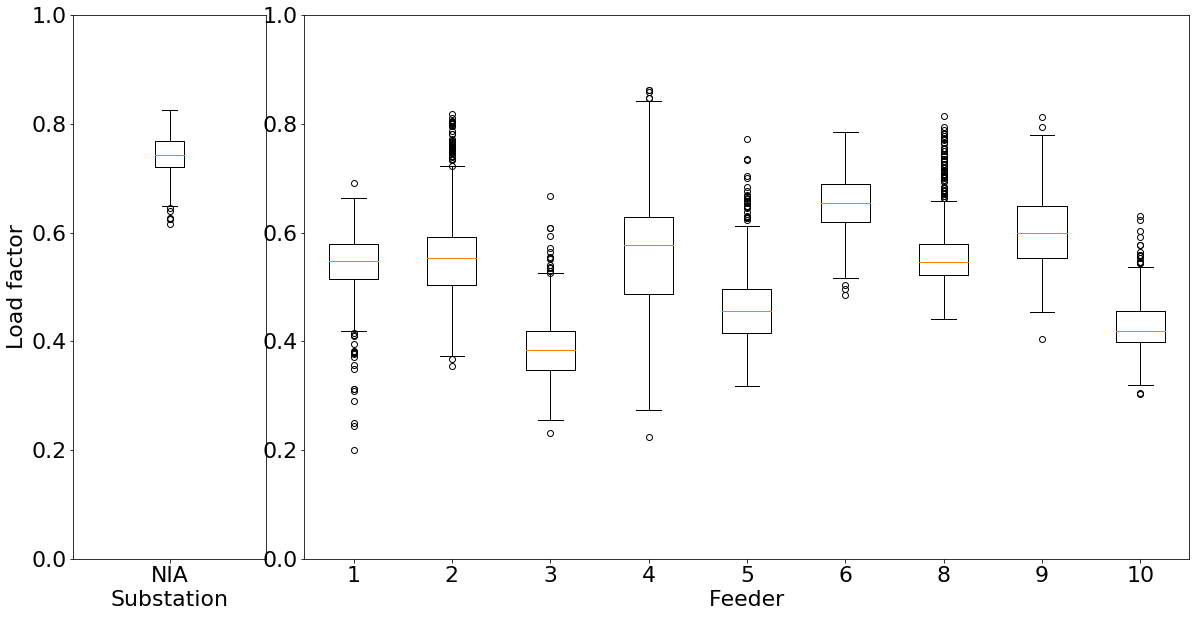

In [18]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(1,5)

ax1 = plt.subplot2grid((1,5), (0,0), colspan=1, rowspan=1)
data=[x for x in list(df_AMR_data['LF_SUB']) if x is not "None"]
ax1.boxplot(data)
ax1.set_ylim(0,1)
ax1.set_xticklabels(['NIA'])
ax1.set_xlabel('Substation')
ax1.set_ylabel('Load factor')

ax2 = plt.subplot2grid((1,5), (0,1), colspan=5, rowspan=1)
data=[[x for x in list(df_AMR_data['LF_OUT{}'.format(feeder)]) if x is not "None"] for feeder in ['01','02','03','04','05', '06','08','09','10']]
ax2.boxplot(data)
ax2.set_ylim(0,1)
ax2.set_xticklabels(['1','2','3','4','5','6','8','9','10'])
ax2.set_xlabel('Feeder')
plt.show()
fig_name = 'plot_LF_SUB_NIA.png'

fig.savefig(fig_name)


In [37]:
#add is holiday (weekend, public holiday)
# create weekend column, public holiday column
# df_AMR_data['is_weekend'], df_AMR_data['is_public_holiday']
# df_AMR_data['is_holiday']

#list_Thai_holiday=['mm/dd', ...]
list_Thai_holiday=['01/01','03/01','04/06','04/12','04/13','04/14','04/15','04/12',
                  '05/01','05/14','04/29','06/27','06/28','06/30','12/08','10/13',
                  '12/05','12/10','12/31']
df_AMR_data['is_weekend']=[1 if get_weekday(x,y,z) >=6 else 0 for x,y,z in zip(
    list(df_AMR_data['Day']),list(df_AMR_data['Month']), list(df_AMR_data['Year']))]
df_AMR_data['is_public_holiday']=[1 if '{}/{}'.format(x,y) in list_Thai_holiday else 0 for x,y in zip(list(df_AMR_data['Month']),list(df_AMR_data['Day']))]


df_AMR_data['is_holiday']=[1 if x+y>0 else 0 for x,y in zip(list(df_AMR_data['is_weekend']), list(df_AMR_data['is_public_holiday']))]

print('create is_holiday column in df_AMR_data')

create is_holiday column in df_AMR_data


# create AMR CI

In [40]:
AMR_CI_dict={}
AMR_CI_dict_2={}

for feeder in ['AMR_OUT01', 'AMR_OUT02', 'AMR_OUT03', 'AMR_OUT04', 'AMR_OUT05', 'AMR_OUT06', 'AMR_OUT08', 'AMR_OUT09', 'AMR_OUT10']:
    print(feeder)
    a=np.array([[],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[]])
    #Train set = 2018
    #drop 2019
    temp_df=df_AMR_data.drop(list(np.where(df_AMR_data['Year']!='2018')[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
    temp_df=temp_df.drop(list(np.where(temp_df['is_holiday']!=0)[0])).copy()
    temp_df=temp_df.reset_index(drop=True)

    temp_dict={}
    for data_2 in temp_df[feeder]:
        for data_1 in data_2:
            temp_dict.update({list(data_1.keys())[0]:a})
    
    for day_data in temp_df[feeder]:
        for AMR_data1 in day_data:
            half_hour_load=np.array(get_half_hour_value(list(AMR_data1[list(AMR_data1.keys())[0]])[0]))
            half_hour_load=np.array([[x] for x in half_hour_load])
            if len(half_hour_load) == 48:
                temp_dict[list(AMR_data1.keys())[0]]=np.append(temp_dict[list(AMR_data1.keys())[0]], half_hour_load, axis=1)

    new_dict={}
    for key1 in list(temp_dict.keys()):
        print(temp_dict[key1])
        new_dict.update({key1:{'working_day':{
            'mean':np.mean(temp_dict[key1], axis=1),
            'Quantile_0.0':np.quantile(temp_dict[key1], 0, axis=1),
            'Quantile_0.05':np.quantile(temp_dict[key1], 0.05, axis=1),
            'Quantile_0.1':np.quantile(temp_dict[key1], 0.1, axis=1),
            'Quantile_0.15':np.quantile(temp_dict[key1], 0.15, axis=1),
            'Quantile_0.2':np.quantile(temp_dict[key1], 0.2, axis=1),            
            'Quantile_0.25':np.quantile(temp_dict[key1], 0.25, axis=1),
            'Quantile_0.3':np.quantile(temp_dict[key1], 0.3, axis=1),
            'Quantile_0.35':np.quantile(temp_dict[key1], 0.35, axis=1),
            'Quantile_0.4':np.quantile(temp_dict[key1], 0.4, axis=1),
            'Quantile_0.45':np.quantile(temp_dict[key1], 0.45, axis=1),
            'Quantile_0.5':np.quantile(temp_dict[key1], 0.5, axis=1),
            'Quantile_0.55':np.quantile(temp_dict[key1], 0.55, axis=1),
            'Quantile_0.6':np.quantile(temp_dict[key1], 0.6, axis=1),
            'Quantile_0.65':np.quantile(temp_dict[key1], 0.65, axis=1),
            'Quantile_0.7':np.quantile(temp_dict[key1], 0.7, axis=1),
            'Quantile_0.75':np.quantile(temp_dict[key1], 0.75, axis=1),
            'Quantile_0.8':np.quantile(temp_dict[key1], 0.8, axis=1),
            'Quantile_0.85':np.quantile(temp_dict[key1], 0.85, axis=1),
            'Quantile_0.9':np.quantile(temp_dict[key1], 0.9, axis=1),
            'Quantile_0.95':np.quantile(temp_dict[key1], 0.95, axis=1),
            'Quantile_1.0':np.quantile(temp_dict[key1], 1.0, axis=1),
            'other_stat_values':'xx'}}}) 


    #Train set = 2018
    #drop 2019
    temp_df=df_AMR_data.drop(list(np.where(df_AMR_data['Year']!='2018')[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
#     print(len(temp_df))
    # drop working_day
    temp_df=temp_df.drop(list(np.where(temp_df['is_holiday']!=1)[0])).copy()
    temp_df=temp_df.reset_index(drop=True)

#     print(len(temp_df))

    temp_dict={}
#     temp_dict={list(data1.keys())[0]:a for data1 in data2 for data2 in temp_df[feeder]}
    for data_2 in temp_df[feeder]:
#         print(data_2)
        for data_1 in data_2:
#             print(data_1)
            temp_dict.update({list(data_1.keys())[0]:a})    
    for day_data in temp_df[feeder]:
        for AMR_data1 in day_data:
            half_hour_load=np.array(get_half_hour_value(list(AMR_data1[list(AMR_data1.keys())[0]])[0]))
            half_hour_load=np.array([[x] for x in half_hour_load])
            if len(half_hour_load) == 48:
                temp_dict[list(AMR_data1.keys())[0]]=np.append(temp_dict[list(AMR_data1.keys())[0]], half_hour_load, axis=1)

    for key1 in list(temp_dict.keys()):
        print(temp_dict[key1])
        new_dict[key1].update({'non_working_day':{
            'mean':np.mean(temp_dict[key1], axis=1),
            'Quantile_0.0':np.quantile(temp_dict[key1], 0, axis=1),
            'Quantile_0.05':np.quantile(temp_dict[key1], 0.05, axis=1),
            'Quantile_0.1':np.quantile(temp_dict[key1], 0.1, axis=1),
            'Quantile_0.15':np.quantile(temp_dict[key1], 0.15, axis=1),
            'Quantile_0.2':np.quantile(temp_dict[key1], 0.2, axis=1),            
            'Quantile_0.25':np.quantile(temp_dict[key1], 0.25, axis=1),
            'Quantile_0.3':np.quantile(temp_dict[key1], 0.3, axis=1),
            'Quantile_0.35':np.quantile(temp_dict[key1], 0.35, axis=1),
            'Quantile_0.4':np.quantile(temp_dict[key1], 0.4, axis=1),
            'Quantile_0.45':np.quantile(temp_dict[key1], 0.45, axis=1),
            'Quantile_0.5':np.quantile(temp_dict[key1], 0.5, axis=1),
            'Quantile_0.55':np.quantile(temp_dict[key1], 0.55, axis=1),
            'Quantile_0.6':np.quantile(temp_dict[key1], 0.6, axis=1),
            'Quantile_0.65':np.quantile(temp_dict[key1], 0.65, axis=1),
            'Quantile_0.7':np.quantile(temp_dict[key1], 0.7, axis=1),
            'Quantile_0.75':np.quantile(temp_dict[key1], 0.75, axis=1),
            'Quantile_0.8':np.quantile(temp_dict[key1], 0.8, axis=1),
            'Quantile_0.85':np.quantile(temp_dict[key1], 0.85, axis=1),
            'Quantile_0.9':np.quantile(temp_dict[key1], 0.9, axis=1),
            'Quantile_0.95':np.quantile(temp_dict[key1], 0.95, axis=1),
            'Quantile_1.0':np.quantile(temp_dict[key1], 1.0, axis=1),
            'other_stat_values':'xx'}})
    AMR_CI_dict.update(new_dict)
    AMR_CI_dict_2.update({feeder:new_dict})

    
# np.save('AMR_CI_dict.npy',AMR_CI_dict)
# np.save('AMR_CI_dict_by_feeder.npy',AMR_CI_dict_2)    

print('save AMR_CI_dict.npy and AMR_CI_dict_by_feeder.npy files ')
    

AMR_OUT01
[[0.00581952 0.00532896 0.0053088  ... 0.00725088 0.0073584  0.00704928]
 [0.96477704 0.96417896 0.96460904 ... 0.00728448 0.00723072 0.96349352]
 [0.9648644  0.96354056 0.96327848 ... 0.00727104 0.00726432 0.9632516 ]
 ...
 [0.96645704 0.9683252  0.00462336 ... 0.96222344 0.0069216  0.00714336]
 [0.96700808 0.9647972  0.00468384 ... 0.96259976 0.96169928 0.00720384]
 [0.96702824 0.9653012  0.0046704  ... 0.9608996  0.96369512 0.00724416]]


AttributeError: module 'numpy' has no attribute 'quantile'

# Create AMR dict from raw data

In [76]:
array_tarrif=np.array([2.6295 for x in np.arange(0,18,1)]+[4.2097 for x in np.arange(0,26,1)]+[2.6295 for x in np.arange(0,4,1)])

48

In [143]:
AMR_CI_dict={}
AMR_CI_dict_2={}

for feeder in ['AMR_OUT01', 'AMR_OUT02', 'AMR_OUT03', 'AMR_OUT04', 'AMR_OUT05', 'AMR_OUT06', 'AMR_OUT08', 'AMR_OUT09', 'AMR_OUT10']:
    print(feeder)
    a=np.array([[],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[],
                [],[],[],[],[],[],[],[]])
    #Train set = 2018
    #drop 2019
    temp_df=df_AMR_data.drop(list(np.where(df_AMR_data['Year']!='2018')[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
    temp_df=temp_df.drop(list(np.where(temp_df['is_holiday']!=0)[0])).copy()
    temp_df=temp_df.reset_index(drop=True)

    temp_dict={}
    for data_2 in temp_df[feeder]:
        for data_1 in data_2:
            temp_dict.update({list(data_1.keys())[0]:a})
#     print(temp_dict)
    for day_data in temp_df[feeder]:
        for AMR_data1 in day_data:
            half_hour_load=np.array(get_half_hour_value(list(AMR_data1[list(AMR_data1.keys())[0]])[0]))
            half_hour_load=np.array([[x] for x in half_hour_load])
            if len(half_hour_load) == 48:
                temp_dict[list(AMR_data1.keys())[0]]=np.append(temp_dict[list(AMR_data1.keys())[0]], half_hour_load, axis=1)
#     print(temp_dict.keys())
#     print(np.shape(temp_dict[list(temp_dict.keys())[0]]))
#     print(temp_dict['21652'])

    new_dict={}
    for key1 in list(temp_dict.keys()):
        new_dict.update({key1:{'working_day':{
            'mean':np.mean(temp_dict[key1], axis=0),
            'max':np.max(temp_dict[key1], axis=0),
            'LF':np.mean(temp_dict[key1], axis=0)/np.max(temp_dict[key1], axis=0),
            'cost': (np.transpose(temp_dict[key1])*array_tarrif*1000).sum(axis=1),
        'other':0}}}) 


    #Train set = 2018
    #drop 2019
    temp_df=df_AMR_data.drop(list(np.where(df_AMR_data['Year']!='2018')[0])).copy()
    temp_df=temp_df.reset_index(drop=True)
#     print(len(temp_df))
    # drop working_day
    temp_df=temp_df.drop(list(np.where(temp_df['is_holiday']!=1)[0])).copy()
    temp_df=temp_df.reset_index(drop=True)

#     print(len(temp_df))

    temp_dict={}
#     temp_dict={list(data1.keys())[0]:a for data1 in data2 for data2 in temp_df[feeder]}
    for data_2 in temp_df[feeder]:
#         print(data_2)
        for data_1 in data_2:
#             print(data_1)
            temp_dict.update({list(data_1.keys())[0]:a})    
    for day_data in temp_df[feeder]:
        for AMR_data1 in day_data:
            half_hour_load=np.array(get_half_hour_value(list(AMR_data1[list(AMR_data1.keys())[0]])[0]))
            half_hour_load=np.array([[x] for x in half_hour_load])
            if len(half_hour_load) == 48:
                temp_dict[list(AMR_data1.keys())[0]]=np.append(temp_dict[list(AMR_data1.keys())[0]], half_hour_load, axis=1)

    for key1 in list(temp_dict.keys()):
#         print(temp_dict[key1])
        new_dict[key1].update({'non_working_day':{
            'mean':np.mean(temp_dict[key1], axis=0),
            'max':np.max(temp_dict[key1], axis=0),
            'LF':np.mean(temp_dict[key1], axis=0)/np.max(temp_dict[key1], axis=0),
            'cost':(np.transpose(temp_dict[key1])*array_tarrif*1000).sum(axis=1),
            'other':0}}) 
    AMR_CI_dict.update(new_dict)
    AMR_CI_dict_2.update({feeder:new_dict})

    
np.save('AMR_dict.npy',AMR_CI_dict)
np.save('AMR_dict_by_feeder.npy',AMR_CI_dict_2)    

print('save AMR_dict.npy and AMR_CI_dict_by_feeder.npy files ')
    

AMR_OUT01
AMR_OUT02
AMR_OUT03
AMR_OUT04


/Users/pornchaichaweewat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/pornchaichaweewat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


AMR_OUT05
AMR_OUT06
AMR_OUT08
AMR_OUT09
AMR_OUT10
save AMR_dict.npy and AMR_CI_dict_by_feeder.npy files 


249

dict_keys([21652, 136898, 137091, 137138, 42432, 66543, 21654, 42421, 42423, 43958, 137110, 42422, 21655, 42431, 44834, 56452, 56457, 56458, 124642, 124647, 124649, 124656, 124683, 185767, 56448, 136900, 137094, 164978, 189318, 193781, 44318, 124687, 21689, 44831, 56459, 124678])

In [138]:
AMR_CI_dict[136898]['working_day']['cost'].mean()

56147.73949878086

In [141]:
AMR_CI_dict[136898]['working_day']['cost'].std()

23736.39868244368

In [142]:
AMR_CI_dict[136898]['working_day']['cost']

array([151133.5149872 , 169435.54980098, 161281.74239666, 164577.83346998,
       158825.93212403, 155189.9009211 , 161363.4034387 , 149802.26221792,
        16150.4643631 , 140740.34163321, 150819.89484355, 143983.64291313,
       171549.8845681 , 159963.4603896 , 119116.37594056,  53885.48934869,
       150889.0688952 , 152229.27175959, 112821.48756338, 156968.26394007,
       156072.87188792, 163243.48028781, 140208.4608998 , 159982.81583159,
       158403.22799435, 165294.74016606, 122787.98206501, 141440.75411006,
       144520.58638225, 168609.46527169, 146492.27415364, 244873.27356999,
       152344.56908633, 196552.46799291, 215408.03724806, 163290.08987014,
       156517.98387048, 136086.55514596, 211358.08386389, 162401.41205249,
       160538.97266084, 167134.39860299, 159050.37480421, 125390.34168284,
       149947.53146453, 155704.49367636, 137306.01864358, 155554.86002071,
       158787.26903697, 170521.47359981, 157812.11473768, 133204.95209669,
       152900.34694152, 1

In [249]:
#load npy files
dict_1=np.load('AMR_CI_dict_by_feeder.npy')[()]
dict_2=np.load('AMR_CI_dict.npy')[()]


In [ ]:
a=np.array([[],[]])
print(a)

a=np.append(a, [[1],[2]], axis=1)
a=np.append(a, [[5],[6]], axis=1)
a=np.append(a, [[10],[11]], axis=1)

print(a)

# Other substation

In [454]:
# #read substation file
# with open('raw_files/dict_N1_NIB.json') as json_file:  
#     sub_data = json.load(json_file)

In [453]:
# df_NIB=pd.DataFrame()
# list_feeder=['OUT01','OUT02', 'OUT03', 'OUT04','OUT05', 'OUT06', 'OUT07', 'OUT08', 'OUT09','OUT10']

# #create date column
# df_NIB['Date']=list(sub_data['OUT01']['P_MW'].keys())

# #create feeders data columns
# for feeder in list_feeder:
#     df_NIB['SUB_{}'.format(feeder)]=[get_SUB_metering_data(sub_data,date,feeder) for date in list(df_NIB['Date'])]
    
# print(df_NIB.head())

In [452]:
# #read substation file
# with open('raw_files/dict_N1_NIC.json') as json_file:  
#     sub_data = json.load(json_file)

In [451]:
# df_NIC=pd.DataFrame()
# list_feeder=['OUT01','OUT02', 'OUT03', 'OUT04','OUT05', 'OUT06', 'OUT07', 'OUT08', 'OUT09','OUT10']

# #create date column
# df_NIC['Date']=list(sub_data['OUT01']['P_MW'].keys())

# #create feeders data columns
# for feeder in list_feeder:
#     df_NIC['SUB_{}'.format(feeder)]=[get_SUB_metering_data(sub_data,date,feeder) for date in list(df_NIC['Date'])]
    
# print(df_NIC.head())

In [51]:
xx=np.array([[1,2,3,4],[5,6,7,8]])

In [58]:
np.shape(xx)

(2, 4)

In [57]:
xx.mean(axis=1)

array([2.5, 6.5])

In [72]:
cost=np.array([1,1,2,2])

In [74]:
xx*cost

array([[ 1,  2,  6,  8],
       [ 5,  6, 14, 16]])

In [80]:
np.shape(cost)

(4,)